In [9]:
from sklearn.decomposition import PCA
import hopsworks
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta



In [10]:
project = hopsworks.login(api_key_value="wOWQmzzHeITT5wlJ.FkOButuQ3XpDXSUO1LnTuaNfD7SPWolfF1hateoistsLFFsBF7upULn5z6qKPOIB")
fs = project.get_feature_store() 
headline_fg = fs.get_feature_group(
    name='headlines_new', 
    version=1,
)

headline_df = headline_fg.read()
headline_df = headline_df.sort_values(by='pubdate')

"""
selected_features = headline_fg.select_all()

feature_view = fs.get_or_create_feature_view(
    name='headlines_new',
    version=1,
    query=selected_features,
    logging_enabled=True
)"""
#feature_df = feature_df.sort_values(by='pubdate', ascending=True)
print(headline_df.head())
print(headline_df.tail())

2024-12-03 22:02:59,463 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-03 22:02:59,479 INFO: Initializing external client
2024-12-03 22:02:59,480 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-03 22:03:00,490 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163414
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 
                       pubdate  \
2949 2023-12-01 00:00:00+00:00   
8838 2023-12-01 00:00:00+00:00   
1247 2023-12-01 00:00:00+00:00   
2108 2023-12-01 00:00:00+00:00   
5064 2023-12-01 00:00:00+00:00   

                                                  title  
2949  Danny Macklin: Police find ex-AFC Wimbledon ch...  
8838  Gaza's fear and anger as ceasefire ends and fi...  
1247  COP28: 'The Earth does not belong to us' - Kin...  
2108  Belgium 1-1 Scotland: Visitors relegated to Na...  
5064  Premiership: Harlequins 36-3 Sale - Marcus 

In [11]:
def df_between_dates(df, start_date, end_date):
    return df[(df['pubdate'] >= start_date) & (df['pubdate'] <= end_date)]

df_week = df_between_dates(headline_df, '2024-11-01', '2024-12-3')


now = datetime.now()
days3 = now + timedelta(days=-3)
past_week = now + timedelta(weeks=-1)
past_month = now + relativedelta(months=-1)
past_three_months = now + relativedelta(months=-1)
past_year = now + relativedelta(years=-1)


#df_week = df_between_dates(headline_df, '2024-11-01', '2024-12-3')
dfs = {}
dfs['day3'] = df_between_dates(headline_df, days3.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))
dfs['week'] = df_between_dates(headline_df, past_week.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))
dfs['month'] = df_between_dates(headline_df, past_month.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))
dfs['month3'] = df_between_dates(headline_df, past_three_months.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))
dfs['year'] = df_between_dates(headline_df, past_year.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))

In [12]:
#headlines = headline_df['title'][13000:13500].tolist()
headlines = {}
embeddings = {}
model = SentenceTransformer('all-MiniLM-L6-v2')
for key in dfs.keys():
    headlines[key]= dfs[key]['title'].tolist()
    embeddings[key] = model.encode(headlines[key])
    



2024-12-03 22:03:04,344 INFO: Use pytorch device_name: cpu
2024-12-03 22:03:04,349 INFO: Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/458 [00:00<?, ?it/s]

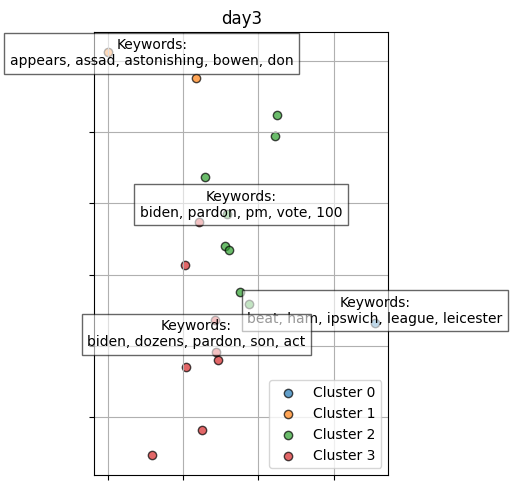

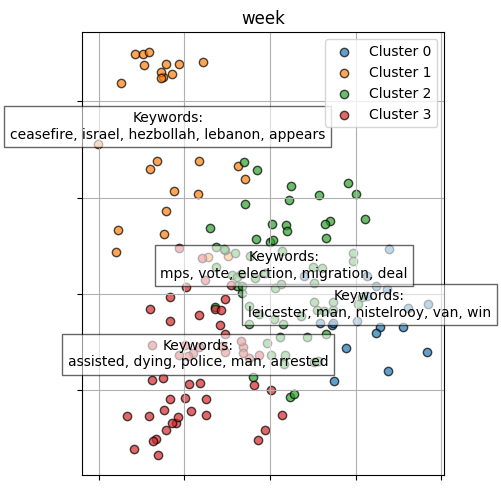

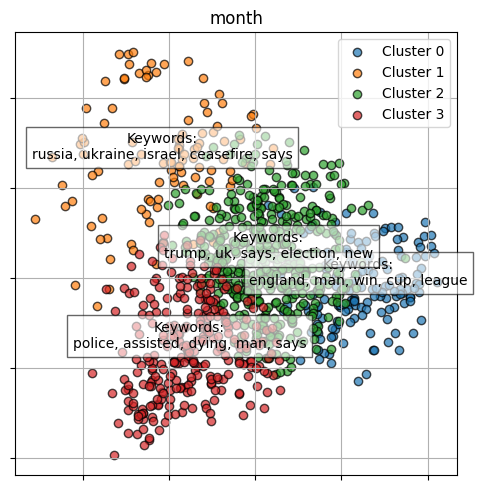

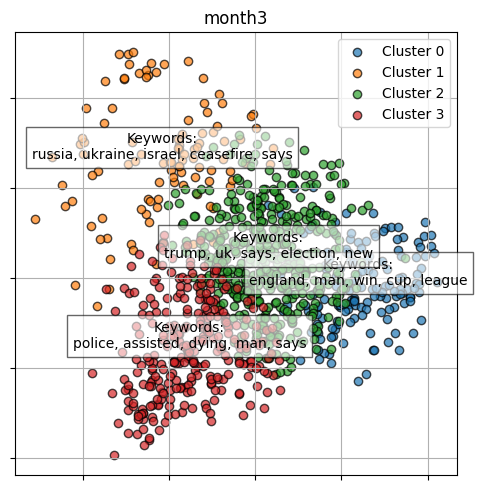

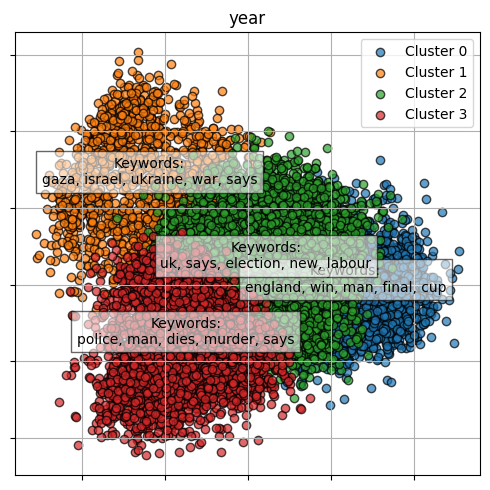

In [13]:
def extract_keywords(clustered_headlines):
    vectorizer = CountVectorizer(stop_words='english')
    keywords = {}
    for cluster_id, headlines in clustered_headlines.items():
        word_counts = vectorizer.fit_transform(headlines)
        word_freq = Counter(dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1)))
        keywords[cluster_id] = [word for word, freq in word_freq.most_common(5)]  # Top 5 keywords
    return keywords

def plot_clusers(keywords, optimal_clusters, embeddings_2d, clusters, title):
    plt.figure(figsize=(5, 5))
    for cluster in range(optimal_clusters):
        cluster_points = embeddings_2d[clusters == cluster]
        plt.scatter(
            cluster_points[:, 0], cluster_points[:, 1],
            label=f"Cluster {cluster}", alpha=0.7, edgecolors='k'
        )
        cluster_center = cluster_points.mean(axis=0)
        plt.text(cluster_center[0], cluster_center[1],
                 f"Keywords:\n{', '.join(keywords[cluster])}",
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.6), ha='center')
    plt.title(title)
    #plt.xlabel("PC 1")
    #plt.ylabel("PC 2")
    plt.legend()
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'docs/cluster_{title}.png')
    plt.show()
    
def training(embeddings, headlines, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=22)
    clusters = kmeans.fit(embeddings) # 1, 2 or 3 for each headline
    
    pca = PCA(n_components=2)
    pca.fit(embeddings)
    return kmeans, pca
    
    
def forward(kmeans,pca,embeddings, headlines, n_clusters=3, title='PCA'):
    clusters = kmeans.predict(embeddings)
    embeddings_2d = pca.transform(embeddings)
    df2 = pd.DataFrame({'headline': headlines, 'cluster': clusters})
    clustered_headlines = df2.groupby('cluster')['headline'].apply(list)

    keywords = extract_keywords(clustered_headlines)
    plot_clusers(keywords, n_clusters, embeddings_2d, clusters, title)

n_clusters=4
kmeans,pca = training(embeddings['year'], headlines['year'], n_clusters)
for key in embeddings.keys():
    forward(kmeans,pca,embeddings[key], headlines[key], n_clusters, title=key)

In [14]:
images = ["docs/cluster_day3.png",
          "docs/cluster_week.png",
          "docs/cluster_month.png",
          "docs/cluster_year.png"]

img1 = Image.open(images[0])
img2 = Image.open(images[1])
img3 = Image.open(images[2])
img4 = Image.open(images[3])

size = img1.size 
img2 = img2.resize(size)
img3 = img3.resize(size)
img4 = img4.resize(size)

combined_width = size[0] * 2
combined_height = size[1] * 2
combined_image = Image.new("RGBA", (combined_width, combined_height))

combined_image.paste(img4, (0, 0))  # Top-left
combined_image.paste(img3, (size[0], 0))  # Top-right
combined_image.paste(img2, (0, size[1]))  # Bottom-left
combined_image.paste(img1, (size[0], size[1]))  # Bottom-right

combined_image.save("docs/combined_image.png")

In [16]:
import pickle
with open("pca_model.pkl", "wb") as pca_file:
    pickle.dump(pca, pca_file)

with open("kmeans_model.pkl", "wb") as kmeans_file:
    pickle.dump(kmeans, kmeans_file)

In [22]:
mr = project.get_model_registry()

pca_model = mr.python.create_model(
    name="PCA_Model",
    description="PCA model for dimensionality reduction"
)
kmeans_model = mr.python.create_model(
    name="KMeans_Model",
    description="KMeans clustering model"
)
pca_model.save('pca_model.pkl')
kmeans_model.save('kmeans_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/5360 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1163414/models/PCA_Model/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/65293 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1163414/models/KMeans_Model/1


Model(name: 'KMeans_Model', version: 1)